### **Tipos de cálculos:**

- Rate of Change: P(hoy)/P(hoy – n días)-1

- RSI (ver librería Análisis Técnico)

- Moving Average

- Standard Deviation

- Beta

In [3]:
import pandas as pd
import numpy as np
import app_functions as af
import plots as pl

In [7]:
prices_df = pd.read_csv('complete_prices.csv',index_col=0)

<AxesSubplot: >

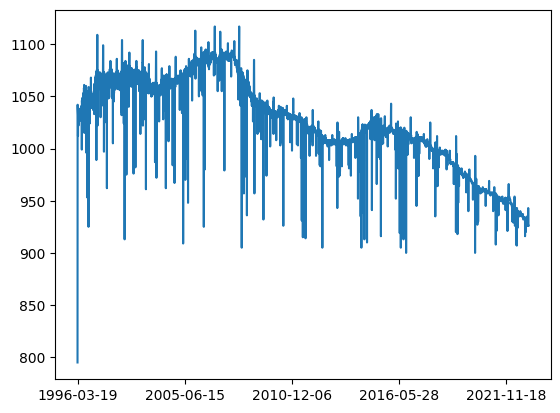

In [8]:
prices_df = prices_df.sort_index().fillna(method='ffill',limit=2)
prices_df.notna().sum(axis=1).plot()

### Rate of change / Momentum
---

In [19]:
pct_change_df = prices_df.pct_change(3)

In [18]:
prices_df.iat[-1,0] / prices_df.iat[-4,0] -1

-0.00894793926247306

In [13]:
prices_df.iat[-5,0]

36.94

### Filter function
---

In [20]:
import json

with open('constituents_filter.json','r') as file:
    consts_filter = json.load(file)

In [40]:
pct_change_df.iloc[0].where(lambda x: 'True' if all(x) > 1 else 'False')

ValueError: Array conditional must be same shape as self